## 第 6 章 与学习相关的技巧
本章将介绍神经网络的学习中的一些重要观点，主题涉及寻找最优权重参数的**最优化方法**、权重参数的**初始值**、**超参数**的设定方法等。此外，为了应对过拟合，本章还将介绍**权值衰减**、**Dropout** 等*正则化*方法，并进行实现。最后将对近年来众多研究中使用的 **Batch Normalization** 方法进行简单的介绍。使用本章介绍的方法，可以**高效地**进行神经网络（深度学习）的学习，提高**识别精度**。
1. 参数的更新
2. 权重的初始值
3. Batch Normalization
4. 正则化
5. 超参数的验证
6. 小结

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from dataset.mnist import load_mnist

### 6.1 参数的更新
在前几章中，为了找到最优参数，我们将参数的梯度（导数）作为了线索。使用参数的梯度，沿梯度方向更新参数，并重复这个步骤多次，从而逐渐靠近最优参数，这个过程称为随机梯度下降法 （ stochastic gradient descent ），但是，根据不同的问题，也存在比 SGD 更加聪明的方法。本节我们将指出 SGD 的缺点，并介绍 SGD 以外的其他最优化方法。

#### 6.1.1 ~ 3 SGD
$$ W \leftarrow W - \eta \cdot \frac{\partial L}{\partial W} $$
虽然 SGD 简单，并且容易实现，但是在解决某些问题时可能**没有效率**。SGD 的缺点是，如果函数的形状非均向（ anisotropic ），比如呈延伸状，搜索的路径就会非常低效(SGD 呈“之”字形移动, 锯齿形（zig-zag）路径)。SGD 低效的根本原因是，梯度的方向并没有指向最小值的方向。为了改正SGD的缺点，下面我们将介绍Momentum、AdaGrad、Adam这3种方法来取代SGD。针对求下面这个函数的最小值的问题。
$$ f(x,y) = \frac{1}{20} x^2 + y^2 $$

#### 6.1.4 Momentum
$$ v \leftarrow \alpha v - \eta \frac{\partial L}{\partial W} $$
$$ W \leftarrow W + v $$
1. 让梯度更新获得“惯性”和“方向记忆”, Momentum 给你的更新加上了一个物理概念：
- 上一步的速度会影响下一步
- 方向一致时速度会叠加
- 方向改变时惯性会抵消抖动

2. 结果就是:
- 在山谷两侧的陡坡区域  
    - SGD：左右乱晃
    - Momentum：惯性抵消掉垂直方向的晃动
- 在真正下降方向
    - SGD：小碎步
    - Momentum：越滚越快，直接“滑”向最优区域

3. 公式拆开理解:
- momentum * v → “惯性”: 如果过去几步都往某个方向走 → 这个方向会被放大
- -η * grad → 当前的梯度推动: 保证你还是顺着下降方向前进

4. 两者结合形成:
- 方向一致 → 速度越来越快
- 方向来回变 → 惯性能减弱震荡

Momentum 是 “动量”的意思，和物理有关。这里新出现了一个变量 v，对应物理上的速度。这就是为什么Momentum比SGD跑得稳、收敛更快。SGD 是看到坡往哪就往哪走。Momentum 是有记忆、有冲量、向着主要方向越走越快的物理加速度。

In [4]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

#### 6.1.5 AdaGrad (Adaptive Gradient)
- 学习率 η 过小，会导致学习花费过多时间；反过来，学习率过大，则会导致学习发散而不能正确进行。
- 学习率衰减 （ learning rate decay ）即随着学习的进行，使学习率逐渐减小(一开始“多”学，然后逐渐“少”学)。
- 与其将“全体”参数的学习率值一起降低, AdaGrad进一步发展了这个想法，针对“一个一个”的参数，赋予其“定制”的值。
- AdaGrad 会为参数的每个元素适当地调整学习率，与此同时进行学习。
$$ h \leftarrow h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} $$
$$ W \leftarrow W - \eta \frac{1}{\sqrt h} \frac{\partial L}{\partial W} = W - \frac{\eta \cdot dW}{\sqrt h}$$
- 变量 h，保存了以前的所有梯度值的平方和（对应矩阵元素的乘法）。
- 在更新参数时，通过乘以 1 / $\sqrt h$，就可以调整学习的尺度。这意味着，参数的元素中变动较大（被大幅更新）的元素的学习率将变小。
- 也就是说，可以按参数的元素进行学习率衰减，使变动大的参数的学习率逐渐减小。

In [12]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

#### 6.1.6 Adam (Momentum + AdaGrad)
- Momentum 参照小球在碗中滚动的物理规则进行移动，AdaGrad 为参数的每个元素适当地调整更新步伐。如果将这两个方法融合在一起就是 Adam方法的基本思路.
- 通过组合前面两个方法的优点，有望实现参数空间的高效搜索。此外，进行超参数的“偏置校正”也是 Adam 的特征。
- 基于 Adam 的更新过程就像小球在碗中滚动一样。虽然Momentun 也有类似的移动，但Adam 的小球左右摇晃的程度有所减轻。这得益于学习的更新程度被适当地调整了。

In [13]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

#### 6.1.7 使用哪种更新方法呢
根据使用的方法不同，参数更新的路径也不同。只看这个图的话，AdaGrad 似乎是最好的，不过也要注意，结果会根据要解决的问题而变。并且，很显然，超参数（学习率等）的设定值不同，结果也会发生变化。并不存在能在所有问题中都表现良好的方法。这4种方法各有各的特点，都有各自擅长解决的问题和不擅长解决的问题。

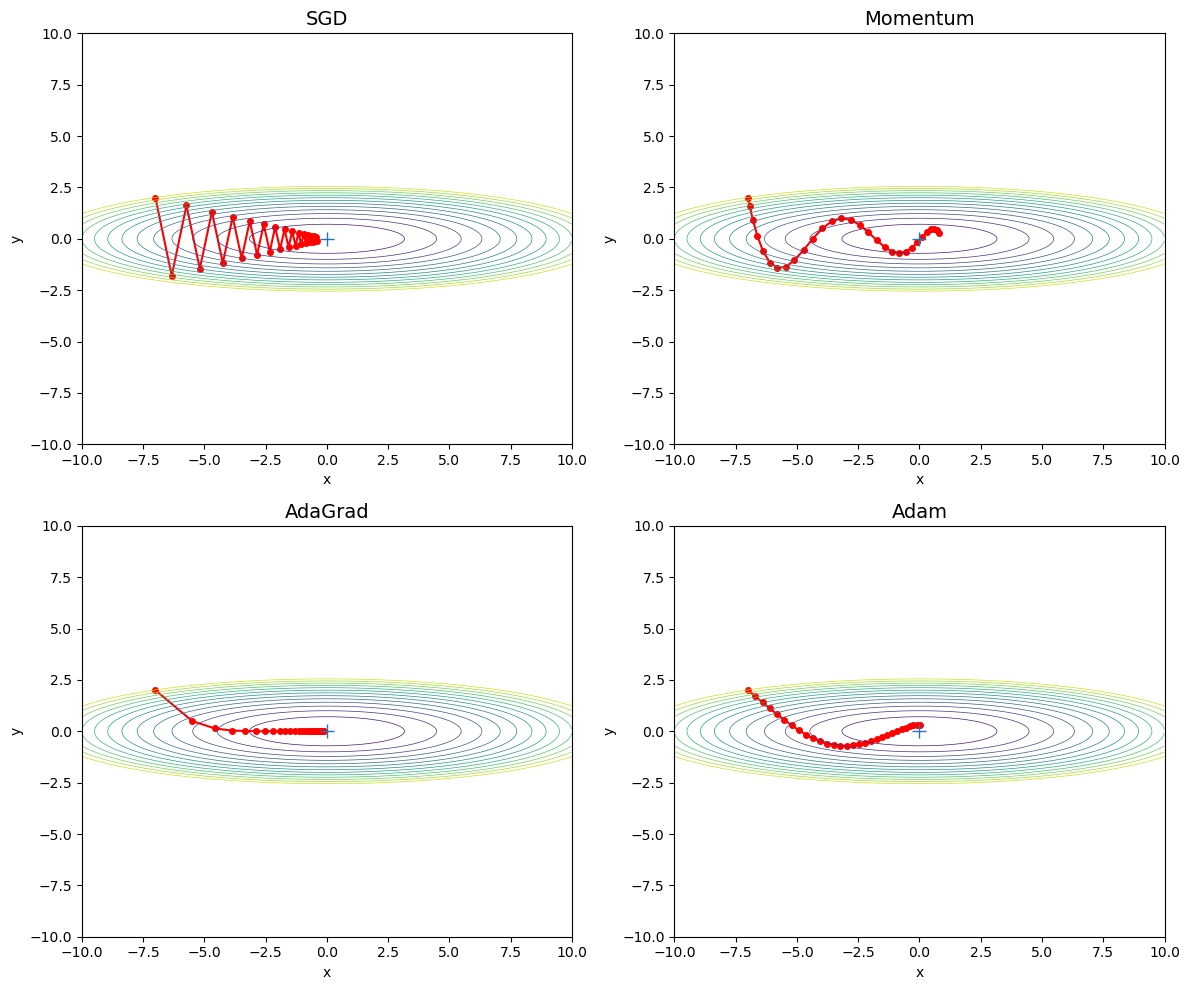

In [16]:
def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # bigger figure
axes = axes.flatten()

for idx, (key, optimizer) in enumerate(optimizers.items()):
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]

    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    mask = Z > 7
    Z[mask] = np.nan

    ax = axes[idx]
    ax.plot(x_history, y_history, 'o-', color="red", markersize=4)
    ax.contour(X, Y, Z, levels=15, linewidths=0.5)
    ax.set_ylim(-10, 10)
    ax.set_xlim(-10, 10)
    ax.plot(0, 0, '+', markersize=10)
    ax.set_title(key, fontsize=14)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()

#### 6.1.8 基于MNIST数据集的更新方法的比较
这个实验以一个 5 层神经网络为对象，其中每层有 100 个神经元。激活函数使用的是 ReLU。与 SGD 相比，其他 3 种方法学习得更快，而且速度基本相同，仔细看的话，AdaGrad 的学习进行得稍微快一点。这个实验需要注意的地方是，实验结果会随学习率等超参数、神经网络的结构（几层深等）的不同而发生变化。不过，一般而言，与 SGD 相比，其他 3 种方法可以学习得更快，有时最终的识别精度也更高。

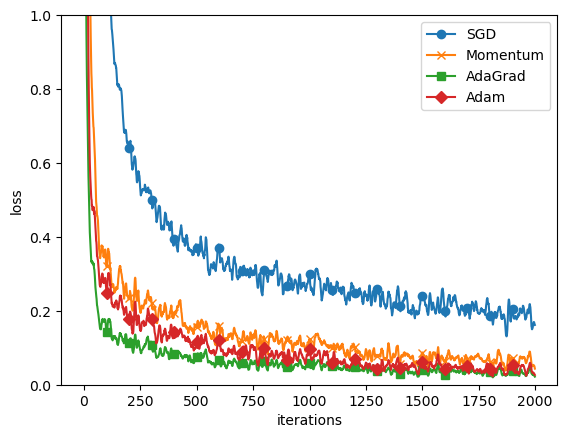

In [19]:
# 此实验运行耗时较长约半分钟
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet

# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    # if i % 100 == 0:
    #     print( "===========" + "iteration:" + str(i) + "===========")
    #     for key in optimizers.keys():
    #         loss = networks[key].loss(x_batch, t_batch)
    #         print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

### 6.2 权重的初始值
在神经网络的学习中，权重的初始值特别重要。实际上，设定什么样的权重初始值，经常关系到神经网络的学习能否成功。本节将介绍权重初始值的推荐值，并通过实验确认神经网络的学习是否会快速进行。

#### 6.2.1 可以将权重初始值设为0吗
